In [ ]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
from collections import OrderedDict


PRI_URLS = OrderedDict({
        2 : 'https://volsu.ru/rating/?plan_id=%D0%90%D0%A0%D0%9C003718&zach=All&semestr=YEAR&group=%D0%9F%D0%A0%D0%98%D0%B1-191',
        3 : 'https://volsu.ru/rating/?plan_id=%D0%90%D0%A0%D0%9C002847&zach=All&semestr=YEAR&group=%D0%9F%D0%A0%D0%98%D0%B1-181',
        4 : 'https://volsu.ru/rating/?plan_id=%D0%90%D0%A0%D0%9C002003&zach=All&semestr=YEAR&group=%D0%9F%D0%A0%D0%98-171'
})

IVT_URLS = OrderedDict({
       2 : 'https://volsu.ru/rating/?plan_id=%D0%90%D0%A0%D0%9C003715&zach=All&semestr=YEAR&group=%D0%98%D0%92%D0%A2%D0%B1-191',
       3 : 'https://volsu.ru/rating/?plan_id=%D0%90%D0%A0%D0%9C002844&zach=All&semestr=YEAR&group=%D0%98%D0%92%D0%A2%D0%B1-181',
       4 : 'https://volsu.ru/rating/?plan_id=%D0%90%D0%A0%D0%9C001999&zach=All&semestr=YEAR&group=%D0%98%D0%92%D0%A2-171'
})

IST_URLS = OrderedDict({
       2 : 'https://volsu.ru/rating/?plan_id=%D0%90%D0%A0%D0%9C003716&zach=All&semestr=YEAR&group=%D0%98%D0%A1%D0%A2%D0%B1-191',
       3 : 'https://volsu.ru/rating/?plan_id=%D0%90%D0%A0%D0%9C002845&zach=All&semestr=YEAR&group=%D0%98%D0%A1%D0%A2%D0%B1-181',
       4 : 'https://volsu.ru/rating/?plan_id=%D0%90%D0%A0%D0%9C002002&zach=All&semestr=YEAR&group=%D0%98%D0%A1%D0%A2-171'
})

In [2]:
def parse_page(url):
       request = requests.get(url)
       soup = BeautifulSoup(request.text, features='html.parser')
       rows = soup.find_all('tr')

       table = []
       headers = []
       for header in rows[0]:
              if header == '\n':
                     pass;
              elif header.find('div'):
                     header_divs = header.find_all('div')
                     # header_divs = header_divs[0].text
                     semi_header = header_divs[0].text
                     if len(header_divs[2].text) != 0:
                            semi_header = "{0} {1}".format(semi_header, header_divs[2].text)
                     headers.append(semi_header)
              else:
                     headers.append(header.text)

       table.append(headers)

       for row in rows[1::]:
              cells = row.find_all('td')
              cells_data = []
              for cell in cells:
                     cells_data.append(cell.text)

              table.append(cells_data)

       return table


def make_dataframes(group_urls):
       group_dataframes = []

       for url in group_urls:
              group_table = parse_page(url)
              group_df = pd.DataFrame(group_table[1::], columns=group_table[0])
              group_dataframes.append(group_df)

       return group_dataframes


def drop_no_data_rows(dataframe):
    for column in dataframe.columns:
        indexes = dataframe.index[dataframe[column] == 'Нет данных']
        if len(indexes) != 0:
            indexes = indexes[::-1]
            for index in indexes:
                dataframe = dataframe.drop(index, axis=0)
                
    return dataframe


def cast_data_to_int(dataframe):
    return dataframe[dataframe.columns[1::]].astype('int32')


def process_dataframe_to_plot(dataframe):    
    dataframe = drop_no_data_rows(dataframe)
    dataframe = cast_data_to_int(dataframe)
    dataframe = drop_zero_score_sum(dataframe)
    
    return dataframe


def add_group_name_column(dataframe, group_name):
    dataframe['Группа'] = group_name
    
    return dataframe


def merge_semesters(semester_dataframes):
       merged_semesters = semester_dataframes[0]
       for semester_dataframe in semester_dataframes[1::]:
              merged_semesters = pd.merge(left=merged_semesters, right=semester_dataframe,
                                         left_on='№ зачетной книжки', right_on='№ зачетной книжки')
           
       return merged_semesters


def drop_zero_score_sum(dataframe):
    dataframe['Сумма баллов'] = dataframe.sum(axis=1)
    dataframe = dataframe[dataframe["Сумма баллов"] != 0]
    
    return dataframe.drop('Сумма баллов', axis=1)


def gen_urls(group_urls):
       for key, value in group_urls.items():
              urls = []
              semesters = key * 2
              for i in range(1, semesters):
                     url = value.replace('YEAR', str(i))
                     urls.append(url)

              group_urls[key] = urls

In [89]:
gen_urls(PRI_URLS)
# pri_191_urls = [pair[1] for pair in list(PRI_URLS.items())][0]
# pri_191_dataframes = make_dataframes(pri_191_urls)
# pri_181_urls = [pair[1] for pair in list(PRI_URLS.items())][1]
# pri_181_dataframes = make_dataframes(pri_181_urls)
pri_171_urls = [pair[1] for pair in list(PRI_URLS.items())][2]
pri_171_dataframes = make_dataframes(pri_171_urls)

gen_urls(IVT_URLS)
# ivt_191_urls = [pair[1] for pair in list(IVT_URLS.items())][0]
# ivt_191_dataframes = make_dataframes(ivt_191_urls)
# ivt_181_urls = [pair[1] for pair in list(IVT_URLS.items())][1]
# ivt_181_dataframes = make_dataframes(ivt_181_urls)
ivt_171_urls = [pair[1] for pair in list(IVT_URLS.items())][2]
ivt_171_dataframes = make_dataframes(ivt_171_urls)

gen_urls(IST_URLS)
# ist_191_urls = [pair[1] for pair in list(IST_URLS.items())][0]
# ist_191_dataframes = make_dataframes(ist_191_urls)
# ist_181_urls = [pair[1] for pair in list(IST_URLS.items())][1]
# ist_181_dataframes = make_dataframes(ist_181_urls)
ist_171_urls = [pair[1] for pair in list(IST_URLS.items())][2]
ist_171_dataframes = make_dataframes(ist_171_urls)

In [90]:
classes_sem_1 = [
    '№ зачетной книжки',
    'Алгебра и геометрия Экзамен',
    'Математический анализ Зачет с оценкой'
]

classes_sem_4 = [
    '№ зачетной книжки',
    'Операционные системы Экзамен',
    'Базы данных Экзамен',
    'Численные методы Экзамен'
]

classes_sem_5 = [
    '№ зачетной книжки',
    'Визуальное программирование Зачет с оценкой',
    'Геоинформационные системы Экзамен',
    'Теория вероятностей и математическая статистика Зачет с оценкой',
    'Производственная практика, научно-исследовательская работа Зачет с оценкой'
]

classes_sem_6 = [
    '№ зачетной книжки',
    'Производственная практика, научно-исследовательская работа Зачет с оценкой'
]


In [110]:
ist_171_dataframe_sem_1 = ist_171_dataframes[0][classes_sem_1]
ist_171_dataframe_sem_4 = ist_171_dataframes[3][classes_sem_4]
ist_171_dataframe_sem_5 = ist_171_dataframes[4][classes_sem_5]
ist_171_dataframe_sem_6 = ist_171_dataframes[5][classes_sem_6]

ivt_171_dataframe_sem_1 = ivt_171_dataframes[0][classes_sem_1]
ivt_171_dataframe_sem_4 = ivt_171_dataframes[3][classes_sem_4]
ivt_171_dataframe_sem_5 = ivt_171_dataframes[4][classes_sem_5]
ivt_171_dataframe_sem_6 = ivt_171_dataframes[5][classes_sem_6]

pri_171_dataframe_sem_1 = pri_171_dataframes[0][classes_sem_1]
pri_171_dataframe_sem_4 = pri_171_dataframes[3][classes_sem_4]
pri_171_dataframe_sem_5 = pri_171_dataframes[4][classes_sem_5]
pri_171_dataframe_sem_6 = pri_171_dataframes[5][classes_sem_6]

In [111]:
ivt_171_dataframes[5]

,№ зачетной книжки,"3D технологии: моделирование, сканирование и печать Зачет с оценкой",Инженерная и компьютерная графика Экзамен,Правоведение Зачет,Прикладная физическая культура (Адаптивная физическая культура),Прикладная физическая культура (Легкая атлетика),Прикладная физическая культура (ОФП) Зачет,Проектная деятельность,"Производственная практика, научно-исследовательская работа Зачет с оценкой","Производственная практика, технологическая Зачет с оценкой",Сети и телекоммуникации Экзамен,Технологическое предпринимательство и основы проектной деятельности Зачет,ЭВМ и периферийные устройства Курсовая работа,ЭВМ и периферийные устройства Экзамен,Электроника и схемотехника Зачет с оценкой
0,699424,93,100,82,0,0,91,0,100,97,94,72,95,92,100
1,716444,96,100,79,0,0,91,0,91,91,94,73,91,92,100
2,875419,92,98,82,0,0,72,0,100,92,94,71,100,92,100
3,589757,92,98,78,0,0,85,0,95,92,93,67,96,92,100
4,555356,93,100,81,0,0,75,0,91,91,94,71,91,92,100
5,319512,91,77,80,0,0,63,0,92,92,92,71,80,85,100
6,916848,85,91,79,0,0,63,0,71,95,80,68,91,91,100
7,477526,71,78,79,0,0,91,0,0,91,94,65,83,80,99
8,752829,86,91,78,0,0,60,0,0,96,94,76,71,65,100
9,427297,1,7,0,0,0,0,0,0,0,0,77,0,0,0


In [112]:
ist_171_merged = merge_semesters([ist_171_dataframe_sem_1, ist_171_dataframe_sem_4,
                                  ist_171_dataframe_sem_5, ist_171_dataframe_sem_6])

ivt_171_merged = merge_semesters([ivt_171_dataframe_sem_1, ivt_171_dataframe_sem_4,
                                  ivt_171_dataframe_sem_5, ivt_171_dataframe_sem_6])

pri_171_merged = merge_semesters([pri_171_dataframe_sem_1, pri_171_dataframe_sem_4,
                                  pri_171_dataframe_sem_5, pri_171_dataframe_sem_6])


In [130]:
ivt_171_merged

,Алгебра и геометрия Экзамен,Математический анализ Зачет с оценкой,Операционные системы Экзамен,Базы данных Экзамен,Численные методы Экзамен,Визуальное программирование Зачет с оценкой,Геоинформационные системы Экзамен,Теория вероятностей и математическая статистика Зачет с оценкой,"Производственная практика, научно-исследовательская работа Зачет с оценкой_x","Производственная практика, научно-исследовательская работа Зачет с оценкой_y",Группа
0,105,106,92,100,91,91,100,95,93,100,ИВТ-171
1,91,108,95,100,91,91,98,80,92,91,ИВТ-171
2,71,97,91,75,91,80,92,95,65,0,ИВТ-171
3,72,80,91,100,91,91,98,71,91,100,ИВТ-171
4,71,80,91,100,98,73,75,65,93,71,ИВТ-171
5,60,100,100,100,91,91,91,93,91,91,ИВТ-171
6,60,93,91,100,91,77,78,73,93,95,ИВТ-171
7,60,93,91,71,91,61,72,71,65,0,ИВТ-171
8,80,95,85,100,91,61,79,61,85,92,ИВТ-171


In [114]:
ist_171_merged = process_dataframe_to_plot(ist_171_merged)
ivt_171_merged = process_dataframe_to_plot(ivt_171_merged)
pri_171_merged = process_dataframe_to_plot(pri_171_merged)

add_group_name_column(ist_171_merged, 'ИСТ-171')
add_group_name_column(ivt_171_merged, 'ИВТ-171')
add_group_name_column(pri_171_merged, 'ПРИ-171')

,Алгебра и геометрия Экзамен,Математический анализ Зачет с оценкой,Операционные системы Экзамен,Базы данных Экзамен,Численные методы Экзамен,Визуальное программирование Зачет с оценкой,Геоинформационные системы Экзамен,Теория вероятностей и математическая статистика Зачет с оценкой,"Производственная практика, научно-исследовательская работа Зачет с оценкой_x","Производственная практика, научно-исследовательская работа Зачет с оценкой_y",Группа
0,101,147,100,91,96,92,98,91,92,93,ПРИ-171
1,92,128,100,75,92,91,91,80,93,93,ПРИ-171
2,94,146,60,71,65,73,60,98,60,0,ПРИ-171
3,71,122,91,75,91,91,82,95,92,98,ПРИ-171
4,71,129,91,75,75,95,75,85,91,73,ПРИ-171
5,72,106,91,75,91,84,81,80,91,92,ПРИ-171
6,61,100,91,71,80,79,82,75,91,92,ПРИ-171
7,60,102,91,80,91,91,80,85,91,96,ПРИ-171
8,61,104,91,80,75,75,80,63,65,0,ПРИ-171
9,60,91,61,60,71,60,60,85,92,96,ПРИ-171


In [138]:
groups_dataframe = pd.concat([ist_171_merged, ivt_171_merged, pri_171_merged])

In [140]:
groups_dataframe = groups_dataframe.reset_index(drop=True)
groups_dataframe

,Алгебра и геометрия Экзамен,Математический анализ Зачет с оценкой,Операционные системы Экзамен,Базы данных Экзамен,Численные методы Экзамен,Визуальное программирование Зачет с оценкой,Геоинформационные системы Экзамен,Теория вероятностей и математическая статистика Зачет с оценкой,"Производственная практика, научно-исследовательская работа Зачет с оценкой_x","Производственная практика, научно-исследовательская работа Зачет с оценкой_y",Группа
0,99,139,91,100,100,100,100,98,100,91,ИСТ-171
1,94,133,91,100,91,100,100,100,100,100,ИСТ-171
2,91,121,100,100,91,79,83,85,100,73,ИСТ-171
3,95,91,95,100,91,100,93,93,100,96,ИСТ-171
4,80,113,60,60,62,60,60,61,60,0,ИСТ-171
5,61,121,91,60,80,61,71,71,71,92,ИСТ-171
6,60,106,91,60,66,60,60,61,71,93,ИСТ-171
7,71,107,91,60,100,71,60,61,71,91,ИСТ-171
8,60,106,91,60,92,61,80,66,91,71,ИСТ-171
9,73,96,75,60,65,60,60,65,62,92,ИСТ-171


amean-62.95454545454545
amean-74.44444444444444
amean-70.78571428571429
amean-90.45454545454545
amean-94.66666666666667
amean-108.35714285714286
amean-75.22727272727273
amean-91.88888888888889
amean-79.92857142857143
amean-70.9090909090909
amean-94.0
amean-71.28571428571429
amean-73.72727272727273
amean-91.77777777777777
amean-77.42857142857143
amean-70.5
amean-79.55555555555556
amean-79.57142857142857
amean-69.36363636363636
amean-87.0


C:\Users\offic\anaconda3\lib\site-packages\seaborn\axisgrid.py:392: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


amean-75.85714285714286
amean-69.45454545454545
amean-78.22222222222223
amean-80.57142857142857
amean-74.72727272727273
amean-85.33333333333333
amean-80.42857142857143
amean-45.04545454545455
amean-71.11111111111111
amean-58.92857142857143


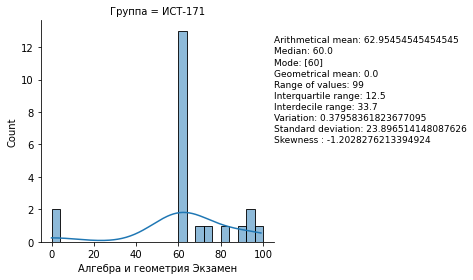

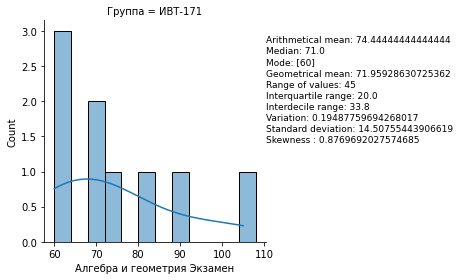

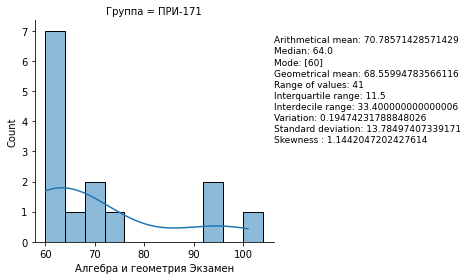

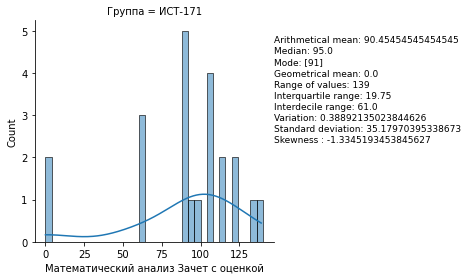

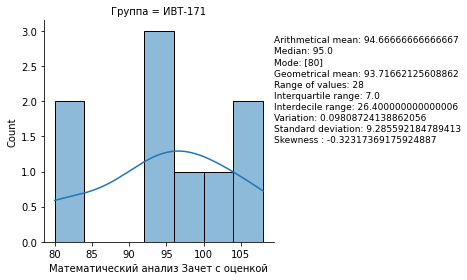

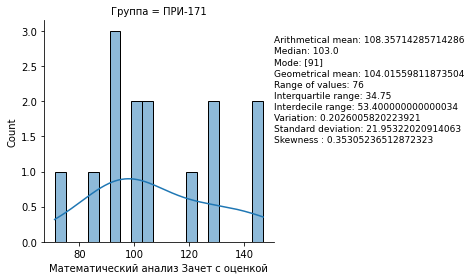

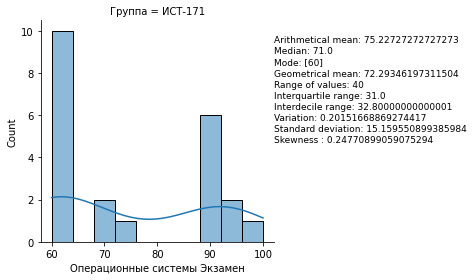

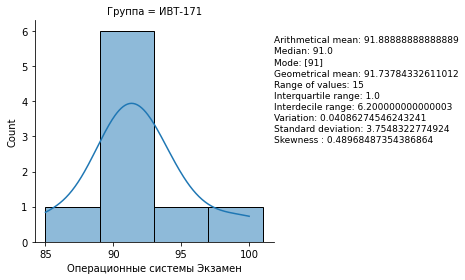

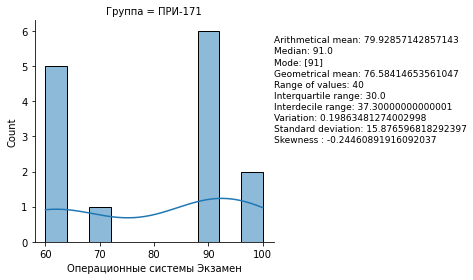

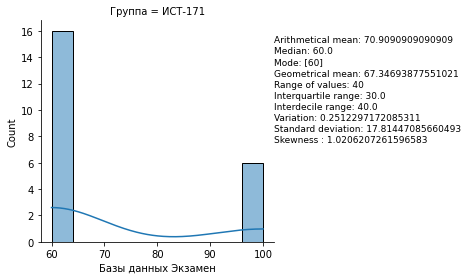

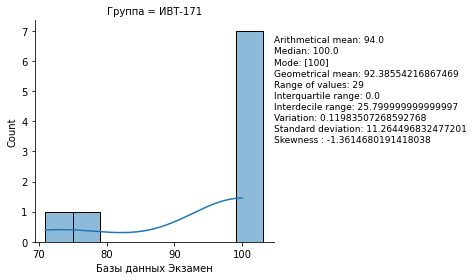

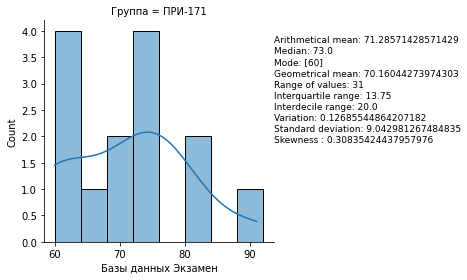

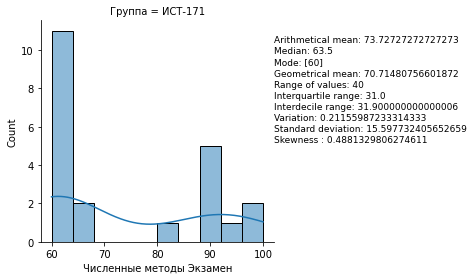

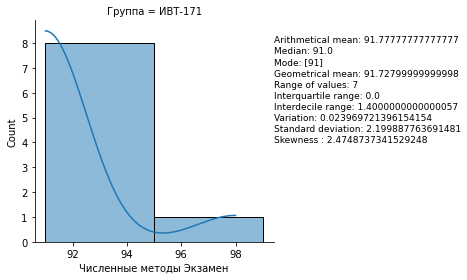

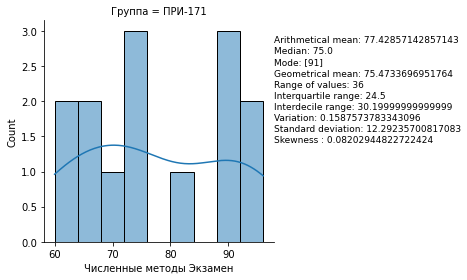

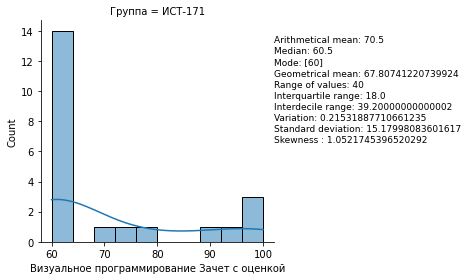

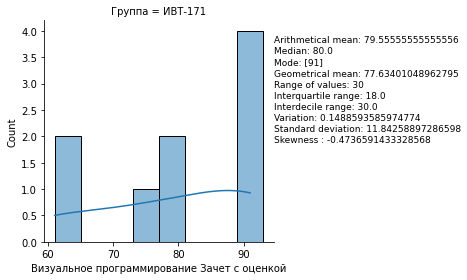

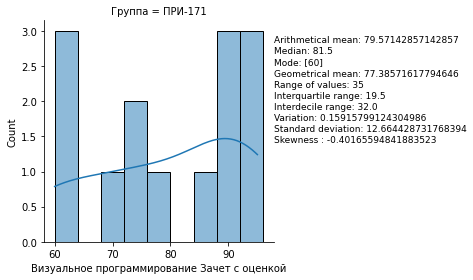

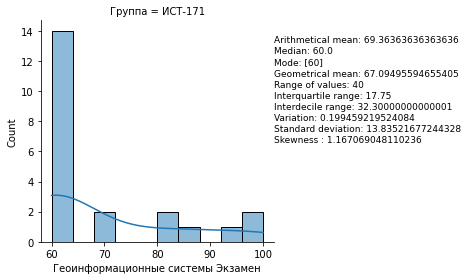

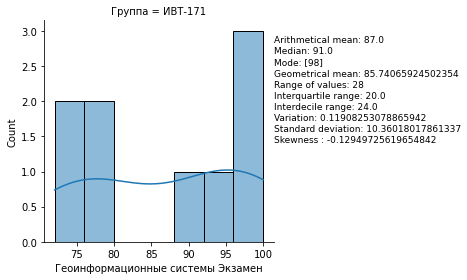

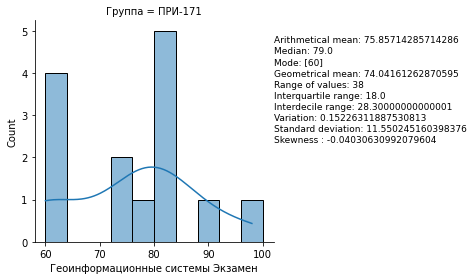

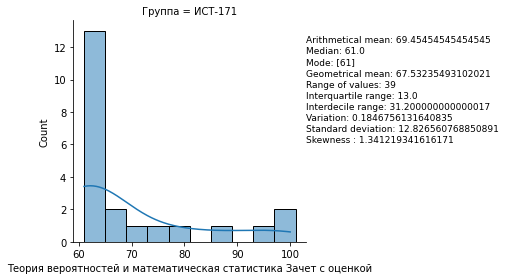

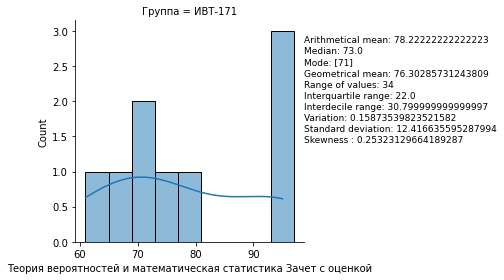

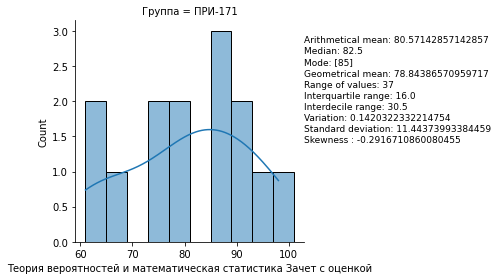

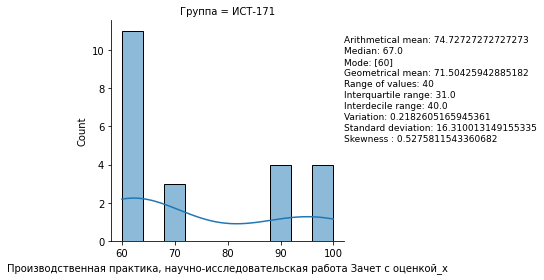

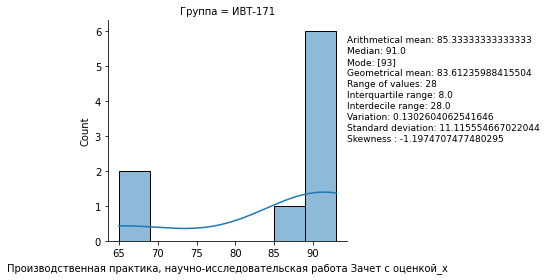

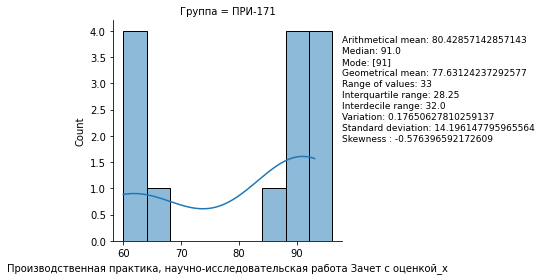

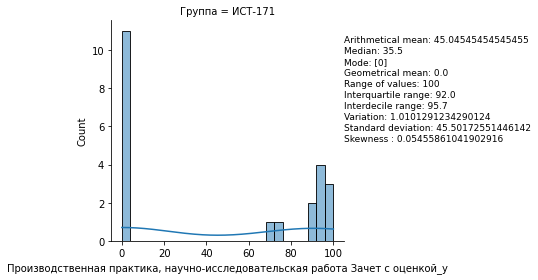

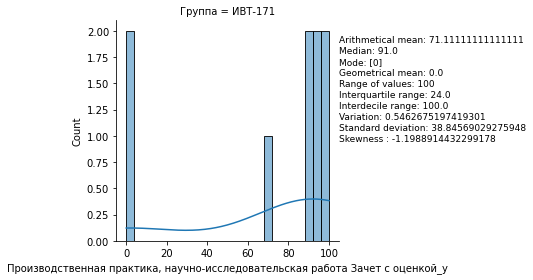

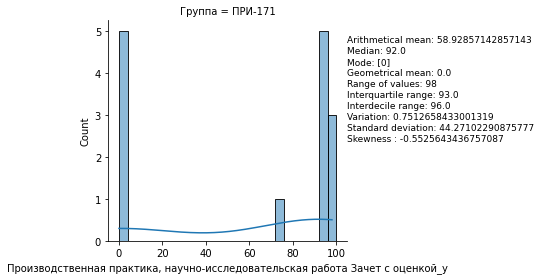

In [177]:
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats


def set_up_statistic(marks, ax):
    # Arithmetical mean
    print('amean-{0}'.format(np.mean(marks)))
    if np.mean(marks) == 0:
        print(marks)
    ax.text(ax.viewLim.intervalx.max(), ax.viewLim.intervaly.max() * 0.90,
            'Arithmetical mean: {0}'.format(np.mean(marks)), fontsize=9)
    # Median
    ax.text(ax.viewLim.intervalx.max(), ax.viewLim.intervaly.max() * 0.85,
            'Median: {0}'.format(np.median(marks)), fontsize=9)
    # Mode
    ax.text(ax.viewLim.intervalx.max(), ax.viewLim.intervaly.max() * 0.80,
            'Mode: {0}'.format(stats.mode(marks)[0]), fontsize=9)
    # Geometrical mean
    ax.text(ax.viewLim.intervalx.max(), ax.viewLim.intervaly.max() * 0.75,
            'Geometrical mean: {0}'.format(stats.hmean(marks)), fontsize=9)
    # Range of values(размах)
    ax.text(ax.viewLim.intervalx.max(), ax.viewLim.intervaly.max() * 0.70,
            'Range of values: {0}'.format(np.ptp(marks)), fontsize=9)
    # Interquartile range(межквартильный  размах)
    ax.text(ax.viewLim.intervalx.max(), ax.viewLim.intervaly.max() * 0.65,
            'Interquartile range: {0}'.format(stats.iqr(marks)), fontsize=9)
    # Interdecile range
    ax.text(ax.viewLim.intervalx.max(), ax.viewLim.intervaly.max() * 0.60,
            'Interdecile range: {0}'.format(stats.iqr(marks, rng=(10,90))), fontsize=9)
    # Variation(дисперсия)
    ax.text(ax.viewLim.intervalx.max(), ax.viewLim.intervaly.max() * 0.55,
            'Variation: {0}'.format(stats.variation(marks)), fontsize=9)
    # Standard deviation
    ax.text(ax.viewLim.intervalx.max(), ax.viewLim.intervaly.max() * 0.50,
            'Standard deviation: {0}'.format(np.std(marks)), fontsize=9)
    # Skewness(коэффициент асимметрии)
    ax.text(ax.viewLim.intervalx.max(), ax.viewLim.intervaly.max() * 0.45,
            'Skewness : {0}'.format(stats.skew(marks)), fontsize=9)


dataframe = pd.read_csv('sexy_dataframe')
subjects = [column for column in dataframe.columns][:-1]
groups = [group for group in dataframe['Группа'].unique()]
for subject in subjects:
    subject_dataframe = dataframe[[subject, 'Группа']]
    for group in groups:
        subject_group_dataframe = subject_dataframe[subject_dataframe['Группа'] == group]
        g = sns.displot(subject_group_dataframe, x=subject, col='Группа', binwidth=4, height=4,
                        facet_kws=dict(margin_titles=True), kde=True)

        subject_marks = np.array([mark for mark in subject_group_dataframe[subject]])
        set_up_statistic(subject_marks, g.ax)
